In [1]:
import os
import pandas as pd
import sys
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from connector import DremioDataframeConnector
pd.set_option('display.max_columns', None)

FONT_BASE = {
    #"family": "sans-serif",
    #"sans-serif": "helvetica",
    "weight": "normal",
    "size": 18,
}

plt.rc("font", **FONT_BASE)
plt.rc("axes", unicode_minus=False)
from matplotlib import rcParams
plt.rcParams.update({'figure.autolayout': True})

In [ ]:
def create_summary_plot(df:pd.DataFrame, field:str, sort=True, annotate=False, truncate=False, title=""):
    """creates a simple count histogram of a particular field, stratified by patient and sample ID"""
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
        
    if sort:
        df_sample = df.groupby(by=[field])['image_id'].nunique().reset_index(name='count').sort_values(['count'], ascending=False).reset_index()

    else:
        df_sample = df.groupby(by=[field])['image_id'].nunique().reset_index(name='count')
    
    index  = df_sample.index
    counts = df_sample['count']
    labels = df_sample[field]
    if truncate:
        index  = index[:10]
        counts = counts[:10]
        labels = labels[:10]
    
    bars = ax1.bar(index, counts)
    ax1.set_xticks(index)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel("Number of Slides")
    if annotate:
        ax1.bar_label(bars)
    

    plt.title(title)
    return plt


In [3]:
# Setup Dremio connector
# Credentials (also could be read via .env)

DREMIO_USER = input("Username: ")
DREMIO_PASSWORD = getpass.getpass(prompt="Password or PAT: ", stream=None)

dremio_session = DremioDataframeConnector(
   scheme="grpc+tcp",
   hostname="tlvidreamcord1",
   flightport=32010,
   dremio_user=DREMIO_USER,
   dremio_password=DREMIO_PASSWORD,
   connection_args={},
)



Username: kohlia
Password or PAT: ········


## HoBBIT casebreakdown

In [4]:
# Querying HoBBIT Casebreakdown table
query = 'select * from "hobbit-poc"."case_breakdown"'
df = dremio_session.get_table(query)
display(df)

[INFO] Query:  select * from "hobbit-poc"."case_breakdown"


,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,1,1,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC RIGHT, (VVS-06...",NaN,None,S06-26206;S1;MSKQ,1,None,None,IPTH9025,aperio,AT2,1006098,20x,$ready,8.400788e+08,2018-03-29 03:22:00
1,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006102,20x,$updated,1.151277e+09,2018-03-29 03:25:00
2,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006106,20x,$updated,9.570065e+08,2018-03-29 03:28:00
3,35039238,S04-43827,R,.GYN,C3,inhouse-surgical,2004-12-06 10:09:09.027,2004-12-09 19:19:54.897,2,2,SMALL BOWEL; BIOPSY,SP: Small bowel (fs) (pjm),NaN,None,S04-43827;S34;MSKS,34,None,None,IPTH9007,aperio,AT2,1011421,20x,$ready,8.993040e+08,2018-04-04 16:55:00
4,00673679,S00-12444,R,None,C,inhouse-surgical,2000-04-24 15:57:00.000,2000-04-28 07:55:00.000,2,2,FROZEN SECTION (FIRST),SP: Prostate and seminal vesicles (fs)(cg),NaN,None,S00-12444;S7;MSKP,7,None,None,IPTH9007,aperio,AT2,1022373,20x,$ready,2.337103e+09,2018-04-14 01:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6297451,38186571,S24-37828,R,.Head & Neck,Surgical,inhouse-surgical,2024-05-13 13:08:54.520,NaT,1,1,LYMPH NODE; RESECTION,"Supra Sternal Notch Level 6 Lymph Nodes, midli...",3.0,3 RT,S24-37828;S3;MSKK,3,"H&E, Initial",H&E (Initial),SS12553,aperio,GT450,8184441,40x,$ready,1.765558e+09,2024-05-16 20:15:00
6297452,38145450,S24-38361,R,.GU,Surgical+,inhouse-surgical,2024-05-14 16:44:05.493,NaT,1,1,PERIPROSTATIC FAT; RESECTION,Periprostatic fat,1.0,1 U,S24-38361;S1;MSKB,1,"H&E, Initial",H&E (Initial),SS12552,aperio,GT450,8184443,40x,$ready,1.087320e+09,2024-05-16 20:17:00
6297453,00912440,M24-23051,MPATH,.Thoracic,DM1,other,2024-05-04 15:29:01.373,NaT,1,1,DM SUBMITTED SLIDES-TUMOR,"Pleura, Right, Fluid (MSK:C24-9823/1-1 CB-F, 1...",NaN,None,M24-23051;S2;MSK7,2,DM H&E RECUT,H&E (Other),SS12389,aperio,GT450,8184456,40x,$ready,2.859338e+09,2024-05-16 20:20:00
6297454,38093602,C24-14272,N,.GI,RUSH tele 74th IR,other,2024-05-07 15:22:09.937,2024-05-10 16:58:45.173,1,1,MISC SPECIMEN,"Liver, Right, Touch Prep of Core Biopsy and Ne...",NaN,None,C24-14272;S1;MSKR,1,Touch PrepTHINPREP/NEEDLE RINSE,Other,Hamamatsu_1,Hamamatsu,S360,8184459,40x,$ready,3.065574e+09,2024-05-16 20:21:00


In [7]:
# Check for missingness
df.isnull().sum(axis=0)

mrn                         0
specnum_formatted           0
specclass_id                0
subspecialty          1272200
priority                   14
reduced_priority            0
datetime_accession          0
signout_datetime        19319
part_inst                   0
part_designator             3
part_type                   0
part_description            0
block_inst             778499
blkdesig_label         778501
barcode                     2
stain_inst                  0
stain_name                290
stain_group             62006
scanner_id                  0
brand                       0
model                       0
image_id                    0
magnification               9
status_id                   0
file_size_bytes           191
captured_datetime           0
dtype: int64

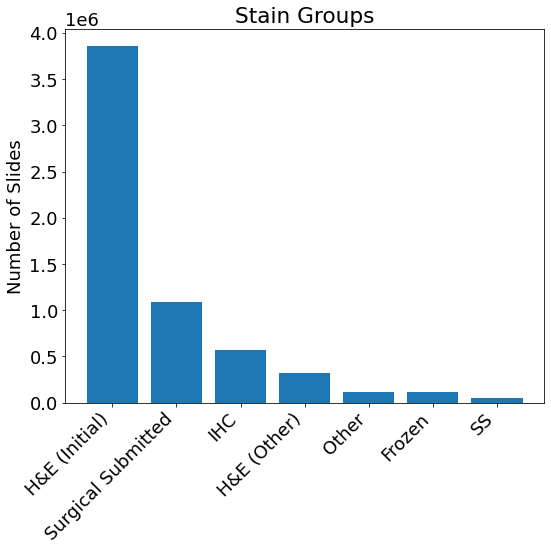

In [50]:
# Plotting Available Stains

plt = create_summary_plot(df, 'stain_group', truncate=True, title='Stain Groups')
plt.savefig("./figures/available_stains.png", bbox_inches='tight')

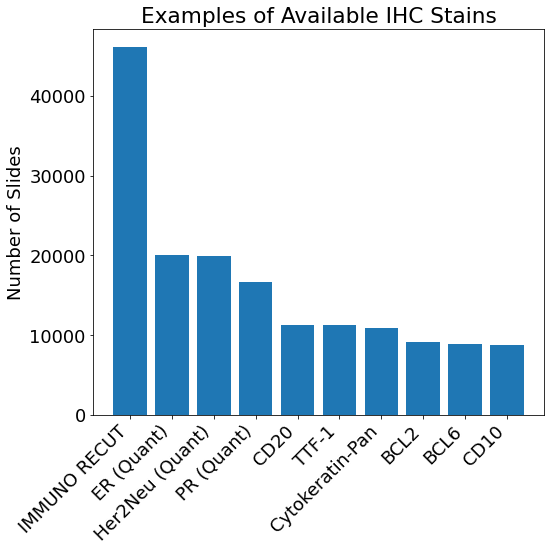

In [51]:
# Plotting available IHC stains

plt = create_summary_plot(df[df['stain_group']=='IHC'], 'stain_name', truncate=True, title='Examples of Available IHC Stains')
plt.savefig("./figures/available_ihc.png", bbox_inches='tight')

magnification,20x,25x,40x,50x,5x
model,,,,,
AT2,3009787,0,24590,0,1
CS2,11476,0,1233,0,2
GT450,4,0,3215684,0,0
HURON Digital TissueScope IQ,0,2195,0,97,0
S360,0,0,13929,0,0
XT,186,0,0,0,0
gt450,0,0,18263,0,0


/var/folders/nn/xf4f68s569q0_lx5m8rrd7grpqnrjr/T/ipykernel_92432/2920322807.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig("./figures/magnification.png", bbox_inches='tight')
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


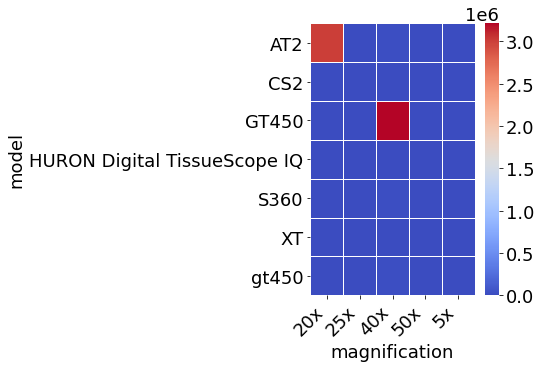

In [42]:
# Plotting available slide magnifications by scanner model

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 6)) #, figsize=(32,32))

_df = pd.crosstab(df['model'], df['magnification'])
display(_df)

fig = sns.heatmap(_df, linewidths=0.5, cmap="coolwarm", annot=False)
fig.set_xticklabels(labels=_df.columns, rotation=45, ha='right') #, labelsize=8)
plt.savefig("./figures/magnification.png", bbox_inches='tight')